<a href="https://colab.research.google.com/github/rezu98/colab/blob/main/STM_FOMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
######################################
### TOPIC MODELING OF FOMC MINUTES ###
######################################

### IMPORT LIBRARIES ###

import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [16]:
nlp = spacy.load("en_core_web_sm")

# nlp = spacy.load("en_core_web_lg")
nlp.max_length = 1500000 # In case max_length is set to lower than this (ensure sufficient memory)

In [12]:
### GRAB THE DOCUMENTS BY PARSING URLs ###

# Define URLs for the specific FOMC minutes
URLPath = r'https://www.federalreserve.gov/monetarypolicy/fomcminutes'
URLExt = r'.htm'

# List for FOMC minutes from 2007 onward
MinutesList = ['20071031', '20071211', # 2007 FOMC minutes (part-year on new URL format)
           '20080130', '20080318', '20080430', '20080625', '20080805', '20080916', '20081029', '20081216', # 2008 FOMC minutes
           '20090128', '20090318', '20090429', '20090624', '20090812', '20090923', '20091104', '20091216', # 2009 FOMC minutes
           '20100127', '20100316', '20100428', '20100623', '20100810', '20100921', '20101103', '20101214', # 2010 FOMC minutes
           '20110126', '20110315', '20110427', '20110622', '20110809', '20110921', '20111102', '20111213', # 2011 FOMC minutes
           '20120125', '20120313', '20120425', '20120620', '20120801', '20120913', '20121024', '20121212', # 2012 FOMC minutes
           '20130130', '20133020', '20130501', '20130619', '20130731', '20130918', '20131030', '20131218', # 2013 FOMC minutes
           '20140129', '20140319', '20140430', '20140618', '20140730', '20140917', '20141029', '20141217', # 2014 FOMC minutes
           '20150128', '20150318', '20150429', '20150617', '20150729', '20150917', '20151028', '20151216', # 2015 FOMC minutes
           '20160127', '20160316', '20160427', '20160615', '20160727', '20160921', '20161102', '20161214', # 2016 FOMC minutes
           '20172001', '20170315', '20170503', '20170614', '20170726', '20170920', '20171101', '20171213', # 2017 FOMC minutes
           '20180131', '20180321', '20180502', '20180613', '20180801', '20180926', '20181108', '20181219', # 2018 FOMC minutes
           '20190130', '20190320', '20190501', '20190619', '20190731', '20190918', '20191030', '20191211', # 2019 FOMC minutes
           '20200129', '20200315', '20200429', '20200610', '20200729'] # 2020 FOMC minutes

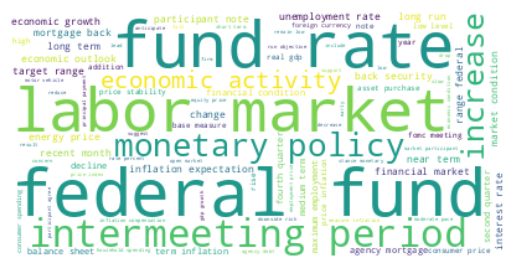

In [19]:
### SETTING UP THE CORPUS ###

FOMCMinutes = [] # A list of lists to form the corpus
FOMCWordCloud = [] # Single list version of the corpus for WordCloud
FOMCTopix = [] # List to store minutes ID (date) and weight of each para

# Define function to prepare corpus
def PrepareCorpus(urlpath, urlext, minslist, minparalength):

    fomcmins = []
    fomcwordcloud = []
    fomctopix = []

    for minutes in minslist:

        response = requests.get(urlpath + minutes + urlext) # Get the URL response
        soup = BeautifulSoup(response.content, 'lxml') # Parse the response

        # Extract minutes content and convert to string
        minsTxt = str(soup.find("div", {"id": "content"})) # Contained within the 'div' tag

        # Clean text - stage 1
        minsTxt = minsTxt.strip()  # Remove white space at the beginning and end
        minsTxt = minsTxt.replace('\r', '') # Replace the \r with null
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        while '  ' in minsTxt:
            minsTxt = minsTxt.replace('  ', ' ') # Remove extra spaces

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)
        minsTxt = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                         '([_]+)|' # Remove series of underscores
                         '(http[^\s]+)|' # Remove website addresses
                         '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                         '', minsTxt) # Replace with null

        # Find length of minutes document for calculating paragraph weights
        minsTxtParas = minsTxt.split('\n') # List of paras in minsTxt, where minsTxt is split based on new line characters
        cum_paras = 0 # Set up variable for cumulative word-count in all paras for a given minutes transcript
        for para in minsTxtParas:
            if len(para)>minparalength: # Only including paragraphs larger than 'minparalength'
                cum_paras += len(para)

        # Extract paragraphs
        for para in minsTxtParas:
            if len(para)>minparalength: # Only extract paragraphs larger than 'minparalength'

                topixTmp = [] # Temporary list to store minutes date & para weight tuple
                topixTmp.append(minutes) # First element of tuple (minutes date)
                topixTmp.append(len(para)/cum_paras) # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text

                # Parse cleaned para with SpaCy
                minsPara = nlp(para)

                minsTmp = [] # Temporary list to store individual tokens

                # Further cleaning and selection of text characteristics
                for token in minsPara:
                    if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB"): # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                        minsTmp.append(token.lemma_.lower()) # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                        fomcwordcloud.append(token.lemma_.lower()) # Add word to WordCloud list
                fomcmins.append(minsTmp) # Add para to corpus 'list of lists'
                fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing

    return fomcmins, fomcwordcloud, fomctopix

# Prepare corpus
FOMCMinutes, FOMCWordCloud, FOMCTopix = PrepareCorpus(urlpath=URLPath, urlext=URLExt, minslist=MinutesList, minparalength=200)

# Generate and plot WordCloud for full corpus
wordcloud = WordCloud(background_color="white").generate(','.join(FOMCWordCloud)) # NB. 'join' method used to convert the documents list to text format
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Form dictionary by mapping word IDs to words
ID2word = corpora.Dictionary(FOMCMinutes)

# Set up Bag of Words and TFIDF
corpus = [ID2word.doc2bow(doc) for doc in FOMCMinutes] # Apply Bag of Words to all documents in corpus
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus] # Apply TF-IDF model

In [ ]:
SEED = 130 # Set random seed
NUM_topics = 8 # Set number of topics
ALPHA = 0.15 # Set alpha
ETA = 1.25 # Set eta

# Train LDA model using the corpus
lda_model = gensim.models.LdaMulticore(corpus=trans_TFIDF, num_topics=NUM_topics, id2word=ID2word, random_state=SEED, alpha=ALPHA, eta=ETA, passes=100)

In [ ]:
# Set up coherence model
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=FOMCMinutes, dictionary=ID2word, coherence='c_v')

# Calculate coherence
coherence_lda = coherence_model_lda.get_coherence()

In [ ]:
para_no = 0 # Set document counter
for para in FOMCTopix:
    TFIDF_para = TFIDF[corpus[para_no]] # Apply TFIDF model to individual minutes documents
    # Generate and store weighted topic proportions for each para
    for topic_weight in lda_model.get_document_topics(TFIDF_para): # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
        FOMCTopix[para_no].append(FOMCTopix[para_no][1]*topic_weight[1]) # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
    para_no += 1

# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF = pd.DataFrame(FOMCTopix, columns=['Date', 'Weight', 'Inflation', 'Topic 2', 'Consumption', 'Topic 4', 'Market', 'Topic 6', 'Topic 7', 'Policy'])

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF = pd.pivot_table(FOMCTopixDF, values=['Inflation', 'Topic 2', 'Consumption', 'Topic 4', 'Market', 'Topic 6', 'Topic 7', 'Policy'], index='Date', aggfunc=np.sum)

In [ ]:
topic = 0 # Initialize counter
while topic < NUM_topics:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    topic += 1

    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
# Plot results - select which topics to print
TopixAggDF.plot(y=['Inflation', 'Consumption', 'Market', 'Policy'], kind='line', use_index=True)